<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/Bankruptcy_RunEachModel_Separate_Cells_08_43.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bankruptcy Prediction – Run models separately (per-cell)

**แนวคิด:** รันแต่ละโมเดลแยก cell เพื่อช่วยดีบัก/ควบคุมหน่วยความจำได้ง่ายขึ้น และใช้ **train/test split ร่วมกัน**

ลำดับรันแนะนำ:
1) Load `df` (หรือข้ามถ้าคุณมี `df` อยู่แล้ว)
2) Feature selection (X,y) + map target (alive→0, failed→1)
3) Import & class definitions
4) สร้าง Controller
5) **Split & Share** (เตรียม `shared_split`)
6) รันแต่ละโมเดล (LogReg / DT / RF / NB / SVM / Perceptron / MLP / PCA+RF / PCA+SVM / KMeans / Agglo)
7) Benchmark table, ROC curves, Loss curve


In [1]:
# ===== Setup & Installs (Kaggle usually has most of these; safe to re-run) =====
!pip -q install kagglehub shap lightgbm xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

import shap
import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 MB 1.4 MB/s eta 0:00:00


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshx27/american-companies-bankruptcy-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.47M/4.47M [00:00<00:00, 166MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3


In [7]:
from kagglehub import KaggleDatasetAdapter, load_dataset

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Set the CSV file path **inside** the dataset (adjust if needed)
# Explore the dataset directory printed below to confirm the file name.
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
file_path = "/root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3/american_bankruptcy.csv"

df = pd.read_csv(file_path)

print("Loaded shape:", df.shape)
print("Columns:\n", list(df.columns))
df.head()

Loaded shape: (78682, 21)
Columns:
 ['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [9]:
# ==============================
# Load your DataFrame (df)
# ==============================
try:
    df  # noqa: F821
    print("✅ Found existing `df`.")
except NameError:
    import pandas as pd
    print("ℹ️ No existing `df` found. Creating a tiny placeholder. Replace with your CSV load.")
    df = pd.DataFrame({
        "X8":[0.1,0.2,0.3,0.4],
        "X17":[1,2,3,4],
        "X3":[5,6,7,8],
        "X11":[0,1,0,1],
        "X15":[10,11,12,13],
        "X1":[2,3,4,5],
        "X6":[9,8,7,6],
        "status_label":["alive","failed","alive","failed"],
    })
print("df shape:", df.shape)


✅ Found existing `df`.
df shape: (78682, 21)


In [10]:
# ==============================
# Feature selection (X, y) + map target
# ==============================
import numpy as np
import pandas as pd

FEATURES = ["X8","X17","X3","X11","X15","X1","X6"]
TARGET   = "status_label"

missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
if missing:
    raise ValueError(f"❌ Missing columns in df: {missing}")

df[TARGET] = df[TARGET].astype(str).str.strip().str.lower().map({
    "alive": 0,
    "failed": 1
}).astype(int)

X = df[FEATURES].copy()
y = df[TARGET].copy()

print("✅ X,y ready.")
print("X shape:", X.shape, "| y counts:", dict(pd.Series(y).value_counts()))


✅ X,y ready.
X shape: (78682, 7) | y counts: {0: np.int64(73462), 1: np.int64(5220)}


In [11]:
# ==============================
# Imports
# ==============================
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, f1_score,
    precision_score, recall_score, roc_curve, auc
)

plt.style.use("ggplot")
RANDOM_STATE = 42


In [12]:
# ==============================
# Base & Subclass Models (OOP)
# ==============================
class BaseModel(ABC):
    def __init__(self, X: pd.DataFrame, y: pd.Series, model_params: dict = None, random_state: int = RANDOM_STATE):
        self.X = X
        self.y = y
        self.random_state = random_state
        self.model = None
        self.model_params = model_params if model_params is not None else {}
        self.X_train = None
        self.X_test  = None
        self.y_train = None
        self.y_test  = None
        self.scaler = StandardScaler()
        self.history = None
        self.is_fitted = False

    def split_data(self, test_size: float = 0.2, scale: bool = True):
        X_train_raw, X_test_raw, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=self.random_state, stratify=self.y
        )
        if scale:
            self.X_train = pd.DataFrame(self.scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
            self.X_test  = pd.DataFrame(self.scaler.transform(X_test_raw), columns=X_test_raw.columns)
        else:
            self.X_train = X_train_raw
            self.X_test  = X_test_raw

    @abstractmethod
    def build_model(self):
        pass

    def fit(self):
        if self.X_train is None:
            raise ValueError("Data not split. Call .split_data() first.")
        self.build_model()
        self.model.fit(self.X_train, self.y_train)
        self.is_fitted = True
        if hasattr(self.model, "loss_curve_"):
            self.history = {"loss_curve": self.model.loss_curve_}
        print(f"✅ {self.__class__.__name__} trained.")

    def evaluate(self):
        if isinstance(self.model, (KMeans, AgglomerativeClustering)):
            return {"Note": "Unsupervised Model: Use specific clustering metrics."}

        if self.y_test is None or not self.is_fitted:
            return {"Error": "Model not fitted or Test data not available."}

        y_pred = self.model.predict(self.X_test)
        results = {}
        if len(np.unique(self.y_test)) == 2:
            try:
                tn, fp, fn, tp = confusion_matrix(self.y_test, y_pred).ravel()
                sensitivity = tp / (tp + fn) if (tp + fn) else 0.0
                specificity = tn / (tn + fp) if (tn + fp) else 0.0
                results = {
                    "Loss (MLP only)": getattr(self.model, "loss_", "N/A"),
                    "Confusion Matrix": confusion_matrix(self.y_test, y_pred).tolist(),
                    "Accuracy": accuracy_score(self.y_test, y_pred),
                    "Precision": precision_score(self.y_test, y_pred, zero_division=0),
                    "Sensitivity (Recall)": sensitivity,
                    "Specificity (TNR)": specificity,
                    "F1-score": f1_score(self.y_test, y_pred, zero_division=0),
                    "ROC AUC": "N/A",
                }
                if hasattr(self.model, "predict_proba"):
                    y_proba = self.model.predict_proba(self.X_test)[:, 1]
                    results["ROC AUC"] = roc_auc_score(self.y_test, y_proba)
            except Exception as e:
                results = {"Error": f"Evaluation failed: {e}"}
        else:
            results = {"Accuracy": accuracy_score(self.y_test, y_pred)}
        return results

    def plot_roc(self, ax=None, label_prefix=""):
        if not hasattr(self.model, "predict_proba") or self.y_test is None:
            return
        y_proba = self.model.predict_proba(self.X_test)[:, 1]
        fpr, tpr, _ = roc_curve(self.y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        ax.plot(fpr, tpr, label=f"{label_prefix} (AUC = {roc_auc:.4f})")
        ax.plot([0, 1], [0, 1], "r--")

    def plot_performance_curve(self, ax=None, label_prefix=""):
        if hasattr(self.model, "loss_curve_") and self.model.loss_curve_ is not None:
            if ax is None:
                fig, ax = plt.subplots(1, 1)
            ax.plot(self.model.loss_curve_, label=f"{label_prefix} Loss")
            ax.set_title("Model Loss Curve")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
            ax.legend()

class LogisticRegressionModel(BaseModel):
    def build_model(self):
        self.model = LogisticRegression(random_state=self.random_state, **self.model_params)

class DecisionTreeModel(BaseModel):
    def build_model(self):
        self.model = DecisionTreeClassifier(random_state=self.random_state, **self.model_params)

class RandomForestModel(BaseModel):
    def build_model(self):
        self.model = RandomForestClassifier(random_state=self.random_state, **self.model_params)

class NaiveBayesModel(BaseModel):
    def build_model(self):
        self.model = GaussianNB(**self.model_params)

class SupportVectorMachineModel(BaseModel):
    def build_model(self):
        self.model = SVC(random_state=self.random_state, probability=True, **self.model_params)

class PerceptronModel(BaseModel):
    def build_model(self):
        self.model = Perceptron(random_state=self.random_state, **self.model_params)

class MLPModel(BaseModel):
    def build_model(self):
        self.model = MLPClassifier(random_state=self.random_state, **self.model_params)

class KMeanClustering(BaseModel):
    def build_model(self):
        n_clusters = self.model_params.pop("n_clusters", 2)
        self.model = KMeans(n_clusters=n_clusters, random_state=self.random_state, n_init=10, **self.model_params)
    def fit(self):
        if self.X_train is None:
            raise ValueError("Data not split.")
        self.build_model()
        self.model.fit(self.X_train)
        self.is_fitted = True
        print(f"✅ {self.__class__.__name__} trained.")

class AgglomerativeClusteringModel(BaseModel):
    def build_model(self):
        n_clusters = self.model_params.pop("n_clusters", 2)
        self.model = AgglomerativeClustering(n_clusters=n_clusters, **self.model_params)
    def fit(self):
        if self.X_train is None:
            raise ValueError("Data not split.")
        self.build_model()
        self.model.fit(self.X_train)
        self.is_fitted = True
        print(f"✅ {self.__class__.__name__} trained.")

class ReducedClassifierModel(BaseModel):
    def __init__(self, X, y, classifier_class, n_components, model_params=None, random_state=RANDOM_STATE):
        super().__init__(X, y, model_params, random_state)
        self.classifier_class = classifier_class
        self.n_components = n_components
    def build_model(self):
        pca = PCA(n_components=self.n_components, random_state=self.random_state)
        if self.classifier_class == SVC:
            classifier = SVC(random_state=self.random_state, probability=True, **self.model_params)
        else:
            classifier = self.classifier_class(random_state=self.random_state, **self.model_params)
        self.model = Pipeline(steps=[("pca", pca), ("classifier", classifier)])


In [13]:
# ==============================
# Controller (no run_all)
# ==============================
class ModelController:
    def __init__(self, X: pd.DataFrame, y: pd.Series, test_size: float = 0.2, random_state: int = RANDOM_STATE):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        self.models = self._initialize_models()
        self.results = {}

    def _initialize_models(self):
        svm_params  = {"C": 10, "gamma": "auto", "class_weight": "balanced"}
        rf_params   = {"n_estimators": 150, "class_weight": "balanced_subsample"}
        lr_params   = {"class_weight": "balanced"}
        dt_params   = {"class_weight": "balanced"}
        perc_params = {"class_weight": "balanced"}
        mlp_params  = {"hidden_layer_sizes": (50,), "max_iter": 500}

        return {
            "Logistic Regression": LogisticRegressionModel(self.X, self.y, model_params=lr_params),
            "Decision Tree": DecisionTreeModel(self.X, self.y, model_params=dt_params),
            "Random Forest": RandomForestModel(self.X, self.y, model_params=rf_params),
            "Naïve Bayesian": NaiveBayesModel(self.X, self.y),
            "Support Vector Machine": SupportVectorMachineModel(self.X, self.y, model_params=svm_params),
            "Perceptron (SLP)": PerceptronModel(self.X, self.y, model_params=perc_params),
            "Multi-layer Perceptron (MLP)": MLPModel(self.X, self.y, model_params=mlp_params),
            "PCA(5) + RF": ReducedClassifierModel(self.X, self.y, RandomForestClassifier, n_components=5, model_params=rf_params),
            "PCA(5) + SVM": ReducedClassifierModel(self.X, self.y, SVC, n_components=5, model_params=svm_params),
            "K-Means Clustering (k=2)": KMeanClustering(self.X, self.y, model_params={"n_clusters": 2}),
            "Agglomerative Clustering (k=2)": AgglomerativeClusteringModel(self.X, self.y, model_params={"n_clusters": 2}),
        }

    def get_results(self, model_name: str = None):
        if model_name:
            return self.results.get(model_name, "Model not found or not run.")
        return self.results

    def show_benchmarking(self):
        classification = {k: v for k, v in self.results.items()
                          if isinstance(v, dict) and ('Accuracy' in v or 'ROC AUC' in v)}
        if not classification:
            print("\n⚠️ No classification results to show benchmarking.")
            return
        df_results = pd.DataFrame.from_dict(classification, orient="index")
        metrics_order = ["Accuracy", "ROC AUC", "F1-score", "Precision", "Sensitivity (Recall)", "Specificity (TNR)"]
        cols = [m for m in metrics_order if m in df_results.columns]

        print("\n" + "="*70)
        print("📊 QUANTITATIVE BENCHMARKING RESULTS (Classification Models)")
        print("="*70)
        print(df_results[cols].sort_values(by="Accuracy", ascending=False).to_string(float_format="{:.4f}".format))
        print("\n* ROC AUC may be 'N/A' for models without predict_proba.")

    def plot_all_roc(self):
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
        plotted = False
        for name, m in self.models.items():
            res = self.results.get(name, {})
            if isinstance(m, (KMeanClustering, AgglomerativeClusteringModel)):
                continue
            if res.get("ROC AUC") in ("N/A", None):
                continue
            try:
                m.plot_roc(ax=ax, label_prefix=name)
                plotted = True
            except Exception:
                pass
        if plotted:
            ax.set_title("Receiver Operating Characteristic (ROC) Curve Comparison", fontsize=16)
            ax.set_xlabel("False Positive Rate (1 - Specificity)")
            ax.set_ylabel("True Positive Rate (Sensitivity)")
            ax.legend(loc="lower right")
            plt.show()
        else:
            print("\n⚠️ No ROC Curves available for comparison.")

    def plot_loss_curves(self):
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        found = False
        for name, m in self.models.items():
            if isinstance(m, MLPModel) and hasattr(m.model, "loss_curve_") and m.model.loss_curve_ is not None:
                m.plot_performance_curve(ax=ax, label_prefix=name)
                found = True
        if found:
            ax.set_title("Performance Curve: MLP Loss vs. Epochs", fontsize=16)
            plt.show()
        else:
            print("\n⚠️ No performance (loss) curves found for plotting.")


In [14]:
# ==============================
# Initialize controller
# ==============================
controller = ModelController(X=X, y=y, test_size=0.2, random_state=RANDOM_STATE)
list(controller.models.keys())


['Logistic Regression',
 'Decision Tree',
 'Random Forest',
 'Naïve Bayesian',
 'Support Vector Machine',
 'Perceptron (SLP)',
 'Multi-layer Perceptron (MLP)',
 'PCA(5) + RF',
 'PCA(5) + SVM',
 'K-Means Clustering (k=2)',
 'Agglomerative Clustering (k=2)']

In [15]:
# ==============================
# Split once & share
# ==============================
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    controller.X, controller.y, test_size=controller.test_size,
    random_state=controller.random_state, stratify=controller.y
)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_test  = pd.DataFrame(scaler.transform(X_test_raw), columns=X_test_raw.columns)
shared_split = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
print("✅ Split ready. Train:", X_train.shape, " Test:", X_test.shape)


✅ Split ready. Train: (62945, 7)  Test: (15737, 7)


In [16]:
# --- Logistic Regression ---
name = "Logistic Regression"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ LogisticRegressionModel trained.
Logistic Regression results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[4659, 10034], [137, 907]], 'Accuracy': 0.35368875897566243, 'Precision': 0.08289918654601956, 'Sensitivity (Recall)': np.float64(0.8687739463601533), 'Specificity (TNR)': np.float64(0.31708977063907984), 'F1-score': 0.15135586149353358, 'ROC AUC': np.float64(0.6745447632816002)}


In [17]:
# --- Decision Tree ---
name = "Decision Tree"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ DecisionTreeModel trained.
Decision Tree results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[13888, 805], [845, 199]], 'Accuracy': 0.8951515536633412, 'Precision': 0.19820717131474103, 'Sensitivity (Recall)': np.float64(0.19061302681992337), 'Specificity (TNR)': np.float64(0.9452120057170081), 'F1-score': 0.1943359375, 'ROC AUC': np.float64(0.5679125162684657)}


In [18]:
# --- Random Forest ---
name = "Random Forest"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ RandomForestModel trained.
Random Forest results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[14688, 5], [1013, 31]], 'Accuracy': 0.935311685835928, 'Precision': 0.8611111111111112, 'Sensitivity (Recall)': np.float64(0.029693486590038315), 'Specificity (TNR)': np.float64(0.9996597018988634), 'F1-score': 0.05740740740740741, 'ROC AUC': np.float64(0.8029610432992175)}


In [19]:
# --- Naïve Bayesian ---
name = "Naïve Bayesian"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ NaiveBayesModel trained.
Naïve Bayesian results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[1427, 13266], [51, 993]], 'Accuracy': 0.1537777212937663, 'Precision': 0.06964022722491059, 'Sensitivity (Recall)': np.float64(0.9511494252873564), 'Specificity (TNR)': np.float64(0.0971210780643844), 'F1-score': 0.129778474808861, 'ROC AUC': np.float64(0.5559406400159796)}


In [20]:
# --- Support Vector Machine ---
name = "Support Vector Machine"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ SupportVectorMachineModel trained.
Support Vector Machine results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[4467, 10226], [130, 914]], 'Accuracy': 0.3419330240833704, 'Precision': 0.08204667863554757, 'Sensitivity (Recall)': np.float64(0.8754789272030651), 'Specificity (TNR)': np.float64(0.30402232355543457), 'F1-score': 0.1500328299409061, 'ROC AUC': np.float64(0.6738284422978285)}


In [21]:
# --- Perceptron (SLP) ---
name = "Perceptron (SLP)"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ PerceptronModel trained.
Perceptron (SLP) results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[3435, 11258], [91, 953]], 'Accuracy': 0.27883332274258116, 'Precision': 0.07804438620915569, 'Sensitivity (Recall)': np.float64(0.9128352490421456), 'Specificity (TNR)': np.float64(0.23378479548084122), 'F1-score': 0.14379479441720106, 'ROC AUC': 'N/A'}


In [22]:
# --- Multi-layer Perceptron (MLP) ---
name = "Multi-layer Perceptron (MLP)"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ MLPModel trained.
Multi-layer Perceptron (MLP) results: {'Loss (MLP only)': np.float64(0.22791641772258878), 'Confusion Matrix': [[14684, 9], [1032, 12]], 'Accuracy': 0.933850162038508, 'Precision': 0.5714285714285714, 'Sensitivity (Recall)': np.float64(0.011494252873563218), 'Specificity (TNR)': np.float64(0.9993874634179541), 'F1-score': 0.022535211267605635, 'ROC AUC': np.float64(0.6896698404353938)}


In [23]:
# --- PCA(5) + RF ---
name = "PCA(5) + RF"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ ReducedClassifierModel trained.
PCA(5) + RF results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[14679, 14], [1026, 18]], 'Accuracy': 0.9339137065514392, 'Precision': 0.5625, 'Sensitivity (Recall)': np.float64(0.017241379310344827), 'Specificity (TNR)': np.float64(0.9990471653168176), 'F1-score': 0.03345724907063197, 'ROC AUC': np.float64(0.7220534747826068)}


In [24]:
# --- PCA(5) + SVM ---
name = "PCA(5) + SVM"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ ReducedClassifierModel trained.
PCA(5) + SVM results: {'Loss (MLP only)': 'N/A', 'Confusion Matrix': [[4713, 9980], [142, 902]], 'Accuracy': 0.35680244010929657, 'Precision': 0.08288917478404705, 'Sensitivity (Recall)': np.float64(0.8639846743295019), 'Specificity (TNR)': np.float64(0.32076499013135507), 'F1-score': 0.1512661412040919, 'ROC AUC': np.float64(0.668580484933921)}


In [25]:
# --- K-Means Clustering (k=2) ---
name = "K-Means Clustering (k=2)"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ KMeanClustering trained.
K-Means Clustering (k=2) results: {'Note': 'Unsupervised Model: Use specific clustering metrics.'}


In [26]:
# --- Agglomerative Clustering (k=2) ---
name = "Agglomerative Clustering (k=2)"
m = controller.models[name]
m.X_train, m.X_test = shared_split["X_train"], shared_split["X_test"]
m.y_train, m.y_test = shared_split["y_train"], shared_split["y_test"]
m.fit()
controller.results[name] = m.evaluate()
print(name, "results:", controller.results[name])


✅ AgglomerativeClusteringModel trained.
Agglomerative Clustering (k=2) results: {'Note': 'Unsupervised Model: Use specific clustering metrics.'}


In [27]:
controller.show_benchmarking()


📊 QUANTITATIVE BENCHMARKING RESULTS (Classification Models)
                              Accuracy ROC AUC  F1-score  Precision  Sensitivity (Recall)  Specificity (TNR)
Random Forest                   0.9353  0.8030    0.0574     0.8611                0.0297             0.9997
PCA(5) + RF                     0.9339  0.7221    0.0335     0.5625                0.0172             0.9990
Multi-layer Perceptron (MLP)    0.9339  0.6897    0.0225     0.5714                0.0115             0.9994
Decision Tree                   0.8952  0.5679    0.1943     0.1982                0.1906             0.9452
PCA(5) + SVM                    0.3568  0.6686    0.1513     0.0829                0.8640             0.3208
Logistic Regression             0.3537  0.6745    0.1514     0.0829                0.8688             0.3171
Support Vector Machine          0.3419  0.6738    0.1500     0.0820                0.8755             0.3040
Perceptron (SLP)                0.2788     N/A    0.1438     0.0780

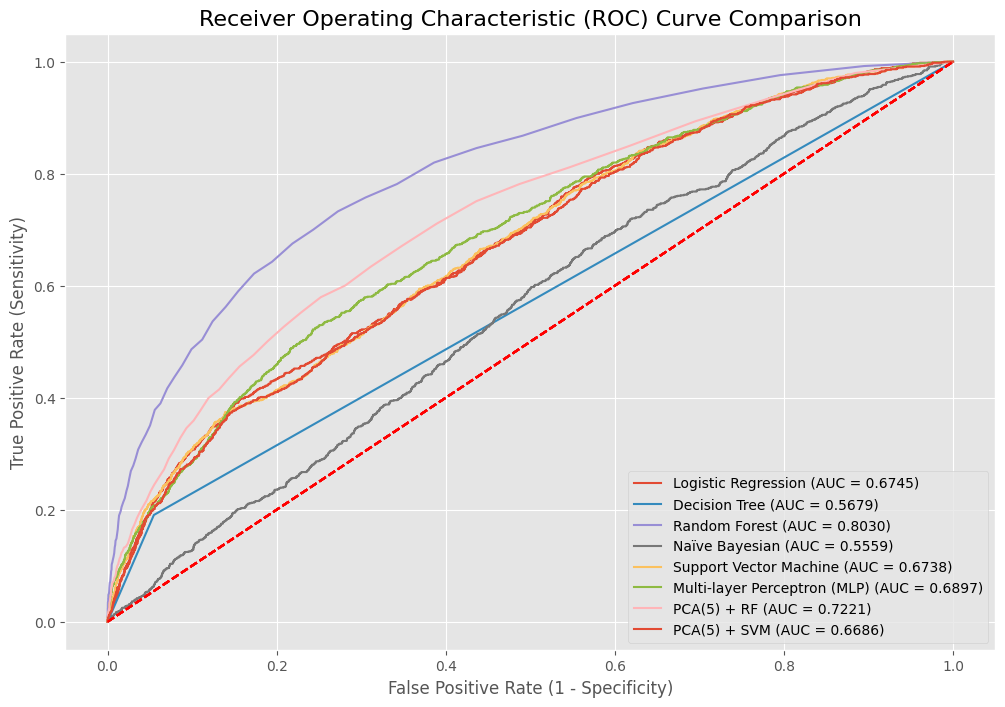

In [28]:
controller.plot_all_roc()

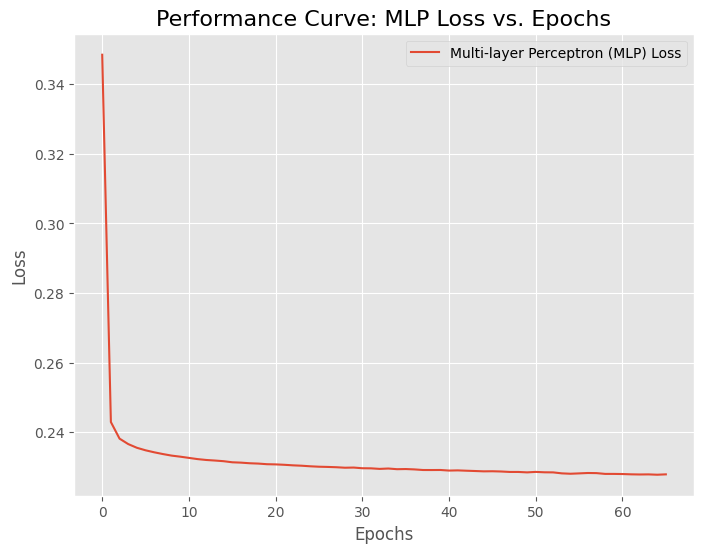

In [29]:
controller.plot_loss_curves()